# Exercise 4.4.1  

**Easy**: Simulate a MA(2) process and make forecasts
* Simulate a stationary MA(2) process. To do so, use the ArmaProcess function from the statsmodels library and simulate the following process:  
    * y<sub>t</sub> = 0.9&theta;<sub>t-1</sub>   + 0.3&theta;<sub>t-1</sub>
    * For this exercise generate 1,000 samples

In [1]:
from statsmodels.tsa.arima_process import ArmaProcess
import numpy as np

np.random.seed(42) #A
ma2 = np.array([1, 0.9, 0.3])
ar2 = np.array([1, 0, 0])
MA2_process = ArmaProcess(ar2, ma2).generate_sample(nsample=1000)

In [2]:
from statsmodels.tsa.seasonal import seasonal_decompose, STL
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import importlib
import sys
import yfinance as yf

import warnings
warnings.filterwarnings('ignore')

sys.path.append('../../My-Code/')

import timetools as tt

importlib.reload(tt)

<module 'timetools' from '/home/oliver/Documents/Code/myrepos/TimeSeriesForecastingInPython/MyWork/../../My-Code/timetools.py'>

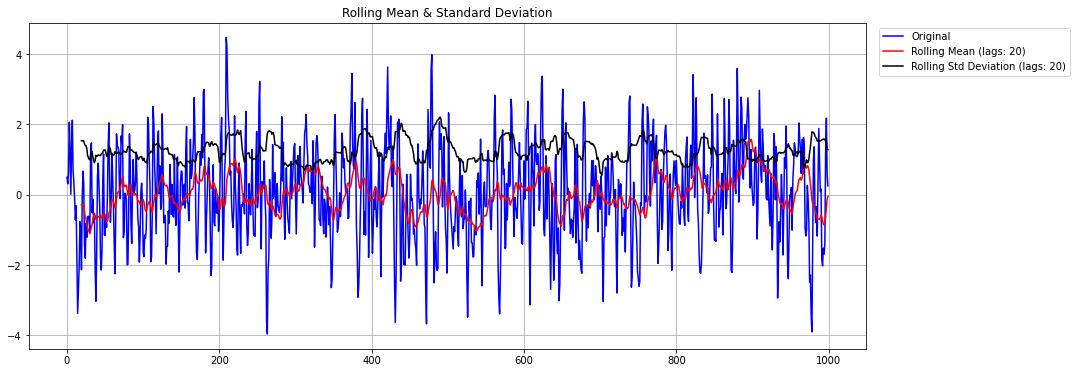

In [3]:
# Plot your simulated moving average.
tt.plot_for_stationary(pd.Series(MA2_process))

In [4]:
# Run the ADF test and check if the process is stationary.
tt.adf(MA2_process)

Test Statistic                -1.400544e+01
p-value                        3.795602e-26
#Lags Used                     3.000000e+00
Number of Observations Used    9.960000e+02
Critical Value (1%)           -3.436933e+00
Critical Value (5%)           -2.864446e+00
Critical Value (10%)          -2.568317e+00
dtype: float64

The time series is stationary.


array([ 1.        ,  0.61524639, -0.35840934])

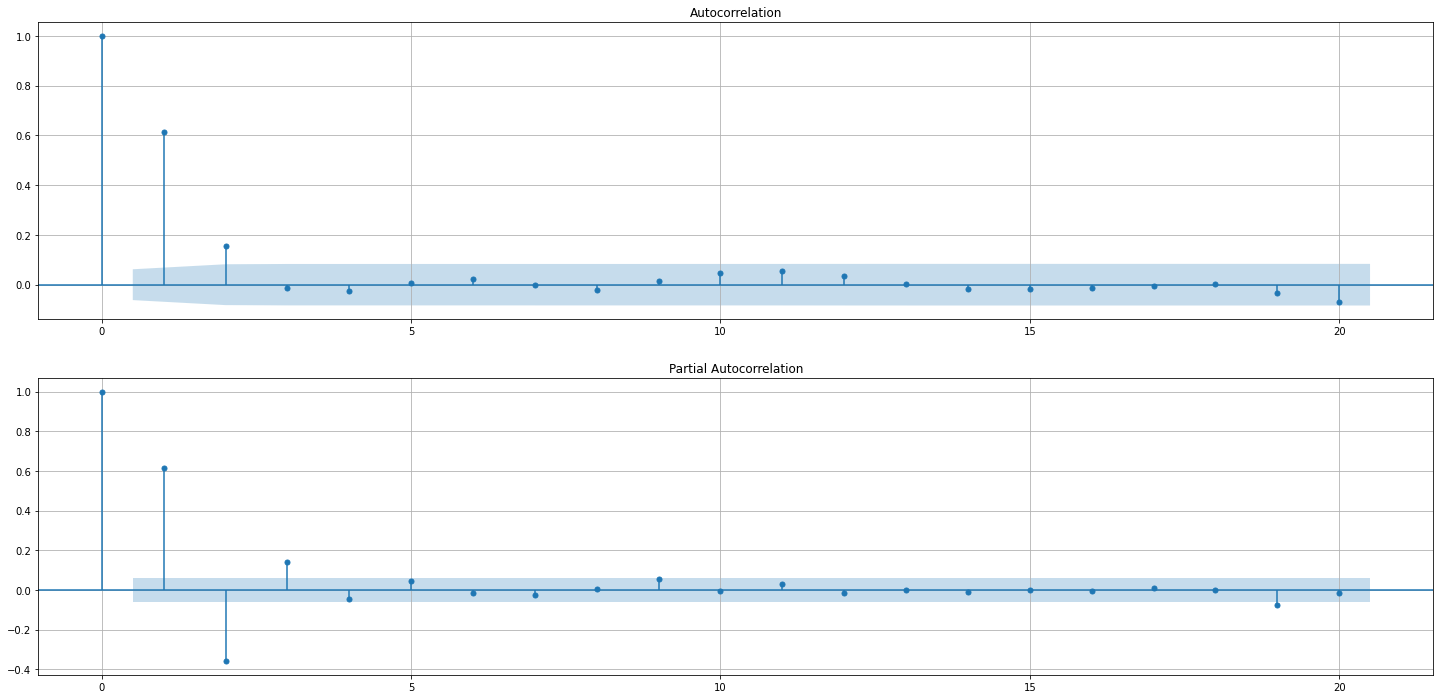

In [11]:
from statsmodels.tsa.stattools import pacf_ols

pacf_ols(MA2_process, nlags=2)

array([ 1.        ,  0.61524639, -0.35840934])

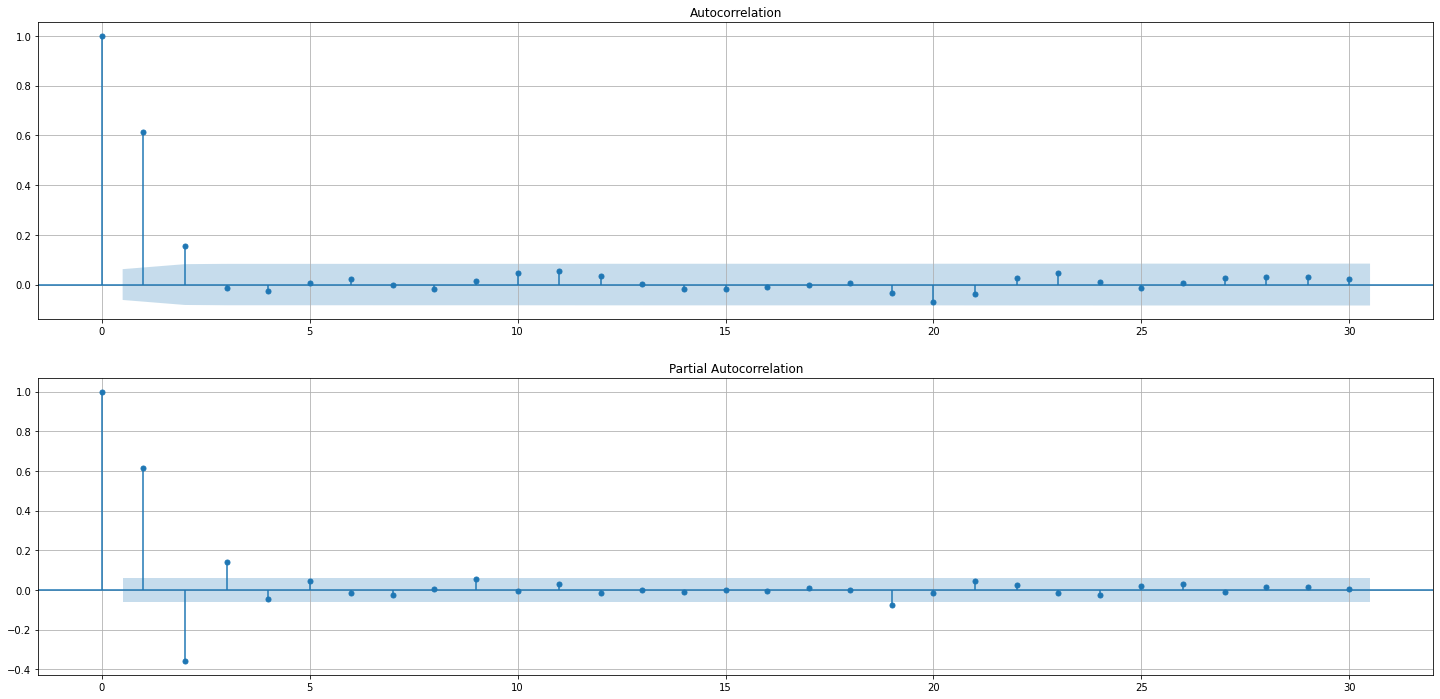

In [14]:
# Plot the ACF and see if there are or are not significant coefficients after lag 2.
tt.plot_acf_pcf(MA2_process, num_lag=30)

from statsmodels.tsa.stattools import pacf_ols

pacf_ols(MA2_process, nlags=2)

In [38]:
df = pd.DataFrame(MA2_process, columns=['value'])
df.tail()

,value
995,-1.387154
996,1.244210
997,2.174431
998,0.544886
999,0.250775


In [39]:
# Separate your simulated series into a training and test set. Take the first 800 timesteps for the training set 
# and assign the rest to the test set.
train, test = df[:800], df[800:]
print('length of train dataset: {}'.format(len(train)))
print('length of test dataset:  {}'.format(len(test)))

length of train dataset: 800
length of test dataset:  200


In [15]:
# Make forecasts over the test set. Use the mean, last value, and a MA(2) model. Make sure to repeatedly forecast 2 timesteps at 
# time using the recursive_forecast function as defined.
from statsmodels.tsa.statespace.sarimax import SARIMAX

def rolling_forecast(df: pd.DataFrame, train_len: int, horizon: int, window: int, method: str) -> list:
    '''
    pred_df   = test.copy()
    TRAIN_LEN = len(train)
    HORIZON   = len(test)
    WINDOW    = 2          ->      predicts next two time steps
    method    =            ->      mean, last, or moving average
    '''
    
    total_len = train_len + horizon
    
    if method == 'mean':
        pred_mean = []
        
        for i in range(train_len, total_len, window):
            mean = np.mean(df[:i].values)
            pred_mean.extend(mean for _ in range(window))

        return pred_mean

    elif method == 'last':
        pred_last_value = []
        
        for i in range(train_len, total_len, window):
            last_value = df[:i].iloc[-1].values[0]
            pred_last_value.extend(last_value for _ in range(window))
            
        return pred_last_value
    
    elif method == 'MA':
        pred_MA = []
        
        for i in range(train_len, total_len, window):
            model = SARIMAX(df[:i], order=(0,0,2))
            res = model.fit(disp=False)
            predictions = res.get_prediction(0, i + window - 1)
            oos_pred = predictions.predicted_mean.iloc[-window:]
            pred_MA.extend(oos_pred)
            
        return pred_MA

In [87]:
# omd
print('df.shape: {}'.format(df.shape[0]))
print('TRAIN_LEN: {}'.format(TRAIN_LEN))
print('HORIZON: {}'.format(HORIZON))
print('WINDOW: {}'.format(WINDOW))

df.shape: 1000
TRAIN_LEN: 800
HORIZON: 200
WINDOW: 2


In [42]:
pred_df = pd.DataFrame(test, columns=['value'])

TRAIN_LEN = len(train)
HORIZON = len(test)
WINDOW = 2

pred_mean = rolling_forecast(df, TRAIN_LEN, HORIZON, WINDOW, 'mean')
pred_last_value = rolling_forecast(df, TRAIN_LEN, HORIZON, WINDOW, 'last')   # omd: the thing is that actual data points for forecast horizon won't be available going forward.  hence this is not a feasible solution.
pred_MA = rolling_forecast(df, TRAIN_LEN, HORIZON, WINDOW, 'MA')

pred_df['pred_mean'] = pred_mean
pred_df['pred_last_value'] = pred_last_value
pred_df['pred_MA'] = pred_MA

pred_df.head(8)

,value,pred_mean,pred_last_value,pred_MA
800,0.973560,-0.017430,0.259693,0.065366
801,0.337338,-0.017430,0.259693,0.017984
802,-0.086834,-0.015752,0.337338,-0.180397
803,-0.530580,-0.015752,0.337338,-0.116820
804,-0.821708,-0.016481,-0.530580,-0.405768
805,-0.838901,-0.016481,-0.530580,-0.123446
806,-0.186470,-0.018501,-0.838901,-0.411563
807,-0.371580,-0.018501,-0.838901,-0.088562


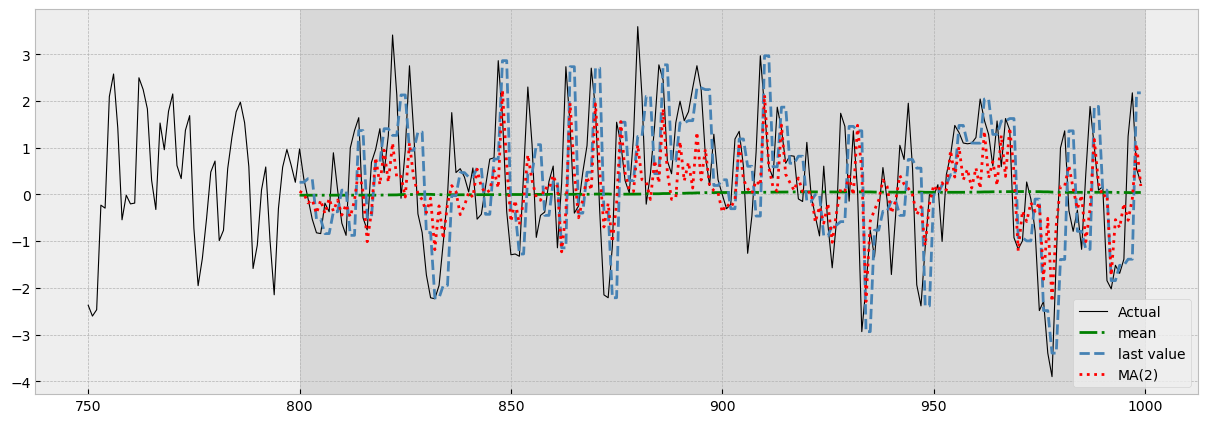

In [66]:
# Plot your forecasts
plt.style.use('bmh')
fig, ax = plt.subplots(figsize=(15, 5))
ax.plot(df[750:], color='black', lw='0.8', label='Actual')
ax.axvspan(xmin=800, xmax=1000, color='#808080', alpha=0.2)
ax.plot(pred_df['pred_mean'], color='green', ls='-.', label='mean')
ax.plot(pred_df['pred_last_value'], color='steelblue', ls='--', label='last value')
ax.plot(pred_df['pred_MA'], color='red', ls='dotted', label='MA(2)')
plt.legend()
plt.show(); plt.style.use('default')

In [70]:
# Measure the MSE and identify your champion model

from sklearn.metrics import mean_squared_error

mse_mean = mean_squared_error(pred_df['value'], pred_df['pred_mean'])
mse_last = mean_squared_error(pred_df['value'], pred_df['pred_last_value'])
mse_MA = mean_squared_error(pred_df['value'], pred_df['pred_MA'])

print(mse_mean, mse_last, mse_MA)

1.8635013982365882 1.988201688527919 1.2323542190610575


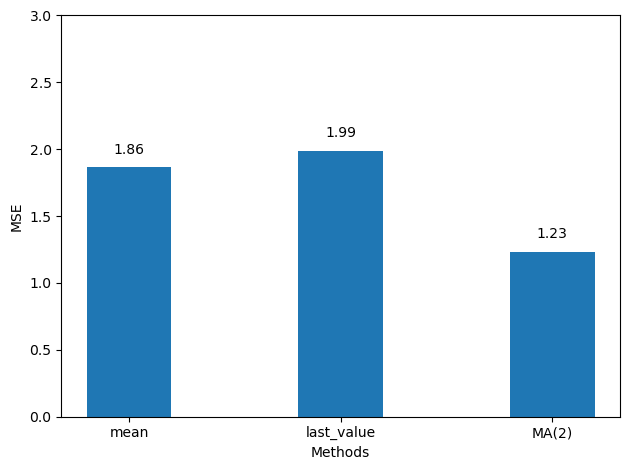

In [78]:
# Plot your MSEs in a bar plot
fig, ax = plt.subplots()

x = ['mean', 'last_value', 'MA(2)']
y = [mse_mean, mse_last, mse_MA]

ax.bar(x, y, width=0.4)
ax.set_xlabel('Methods')
ax.set_ylabel('MSE')
ax.set_ylim(0, 3)

for index, value in enumerate(y):
    plt.text(x=index, y=value+0.1, s=str(round(value, 2)), ha='center')

plt.tight_layout()

plt.savefig('figures/CH04_F09_peixeiro.png', dpi=300)